In [21]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from pryngles import *
from pryngles import pixx
import time
extension="pixx"
#extension="cpixx"
import multiprocessing as mp
import os,sys,glob
from os import listdir
from os.path import isfile, join
from scipy.optimize import minimize, differential_evolution

# Import local functions
import extra_func as efunc

<IPython.core.display.Javascript object>


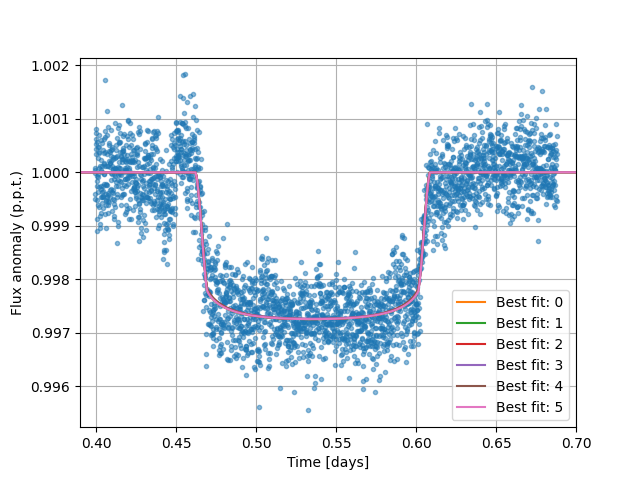

Parameters of best solution number 0: 
b = 0.08395473400942344 ; impact parameter 
ring_i = 14.248388613504552 ; ring_inclination 
ring_l = 13.468584420621314 ; ring roll 
r = 0.3671935154904645 ; planetary radius, in terms of the radius of jupiter 
a = 0.0713533724419052 ; semi-major axis of the orbit 
e = 0.25494027968430477 ; eccentricity of the orbit 
fi = 1.8656004609640984 ; inner radius of ring, in terms of planetary radius 
fe = 2.479751535513729 ; outer radius of ring, in terms of planetary radius 
lincoef = 0.11030984954334136 ; linear limb-darkening coefficient 
quadcoef = 0.22673676559396086 ; quadratic limb-darkening coefficient 
optical_th = 0.002 ; optical thickness of the ring 
particle_r = 40.0 ; radius of the particles 

Parameters of second-best solution number 1: 
b = 0.08395933240732067 ; impact parameter 
ring_i = 14.248388613504552 ; ring_inclination 
ring_l = 13.468584420621314 ; ring roll 
r = 0.36719867215453156 ; planetary radius, in terms of the radius of ju

In [26]:
def extractPlot(save_name,number,best,Mie=False):
    onlyfiles = np.array([f for f in listdir(save_name) if isfile(join(save_name, f))])
    sortedfiles = np.sort(onlyfiles)

    x_sum = np.zeros((12,number))

    if Mie:
        optical_thickness_values = np.array([0.0,0.002,0.01,0.05,0.1,0.2,0.6,
                                             1.0,1.2,1.6,2.0,4.0,8.0])
        particle_r_values = np.array([20,40,80])
    else:
        optical_thickness_values = np.array([0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.4,0.6,0.8,
                                             1.0,1.2,1.4,1.6,1.8,2.0,4.0,6.0,8.0,10.0,20.0])
    
    fig1=plt.figure()
    ax1=fig1.gca()
    
    for i in np.arange(number):
        fitfile_name = save_name + "/" + sortedfiles[i]
        with open(fitfile_name,"rb") as f:
            save_file = pickle.load(f)
        fitx = save_file["Fitx"]
        fity = save_file["Fity"]
        shift = save_file["Shift"]
        x = save_file["x"]
        Ttot = np.array(save_file["Ttot"])
        ts   = np.array(save_file["Time"])
        if Mie:
            optical_thickness = optical_thickness_values[int(x[10])]
            particle_r = particle_r_values[int(x[11])]
            x[11] = particle_r
        else:
            idx = (np.abs(optical_thickness_values - 10**x[10])).argmin()
            optical_thickness = optical_thickness_values[idx]
            x[11] = 1
            
        x[10] = optical_thickness
        x_sum[:,i] = x
        if i == best:
            x0_best=x
            ax1.plot(fitx,fity,'.', alpha=0.5)
            print(f"Parameters of best solution number {best}: \n" +\
                f"b = {x[0]} ; impact parameter \n" +\
                f"ring_i = {x[1]} ; ring_inclination \n" +\
                f"ring_l = {x[2]} ; ring roll \n" +\
                f"r = {x[3]} ; planetary radius, in terms of the radius of jupiter \n" +\
                f"a = {x[4]} ; semi-major axis of the orbit \n" +\
                f"e = {x[5]} ; eccentricity of the orbit \n" +\
                f"fi = {x[6]} ; inner radius of ring, in terms of planetary radius \n" +\
                f"fe = {x[7]} ; outer radius of ring, in terms of planetary radius \n" +\
                f"lincoef = {x[8]} ; linear limb-darkening coefficient \n" +\
                f"quadcoef = {x[9]} ; quadratic limb-darkening coefficient \n" +\
                f"optical_th = {x[10]} ; optical thickness of the ring \n" +\
                f"particle_r = {x[11]} ; radius of the particles \n"
                )
        elif i == best+1:
            print(f"Parameters of second-best solution number {best+1}: \n" +\
                f"b = {x[0]} ; impact parameter \n" +\
                f"ring_i = {x[1]} ; ring_inclination \n" +\
                f"ring_l = {x[2]} ; ring roll \n" +\
                f"r = {x[3]} ; planetary radius, in terms of the radius of jupiter \n" +\
                f"a = {x[4]} ; semi-major axis of the orbit \n" +\
                f"e = {x[5]} ; eccentricity of the orbit \n" +\
                f"fi = {x[6]} ; inner radius of ring, in terms of planetary radius \n" +\
                f"fe = {x[7]} ; outer radius of ring, in terms of planetary radius \n" +\
                f"lincoef = {x[8]} ; linear limb-darkening coefficient \n" +\
                f"quadcoef = {x[9]} ; quadratic limb-darkening coefficient \n" +\
                f"optical_th = {x[10]} ; optical thickness of the ring \n" +\
                f"particle_r = {x[11]} ; radius of the particles \n"
                )

        ax1.plot(ts+shift, Ttot+1, label=f"Best fit: {i}")
        
    ax1.legend()
    ax1.set_xlim([0.39,0.7])
    ax1.set_ylabel("Flux anomaly (p.p.t.)")
    ax1.set_xlabel("Time [days]")
    ax1.grid()
    plt.show()
    
    avg_x = np.mean(x_sum, axis=1)
    std_x = np.std(x_sum,axis=1)
    print( f"Average value of the parameters \n" + \
        f"b = {round(avg_x[0],5)} +- {round(std_x[0],5)} ; impact parameter \n" +\
        f"ring_i = {round(avg_x[1],5)} +- {round(std_x[1],5)} ; ring_inclination \n" +\
        f"ring_l = {round(avg_x[2],5)} +- {round(std_x[2],5)} ; ring roll \n" +\
        f"r = {round(avg_x[3],5)} +- {round(std_x[3],5)} ; planetary radius, in terms of the radius of jupiter \n" +\
        f"a = {round(avg_x[4],5)} +- {round(std_x[4],5)} ; semi-major axis of the orbit \n" +\
        f"e = {round(avg_x[5],5)} +- {round(std_x[5],5)} ; eccentricity of the orbit \n" +\
        f"fi = {round(avg_x[6],5)} +- {round(std_x[6],5)} ; inner radius of ring, in terms of planetary radius \n" +\
        f"fe = {round(avg_x[7],5)} +- {round(std_x[7],5)} ; outer radius of ring, in terms of planetary radius \n" +\
        f"lincoef = {round(avg_x[8],5)} +- {round(std_x[8],5)} ; linear limb-darkening coefficient \n" +\
        f"quadcoef = {round(avg_x[9],5)} +- {round(std_x[9],5)} ; quadratic limb-darkening coefficient \n" +\
        f"optical_th = {avg_x[10]} +- {std_x[10]} ; optical thickness of the ring \n" +\
        f"particle_r = {avg_x[11]} +- {std_x[11]} ; radius of the particles \n"
    )
    return x0_best,avg_x,std_x
    
save_name = "/home/allard/Data/Transit_fit_checked/run_num15" #"/home/allard/Data/Transit_fit/run_num14"
x0_best,avg_x,std_x = extractPlot(save_name,6,0,Mie=True)

# save_name = "/home/allard/Data/Transit_fit/run_num5"
# x0_best,avg_x,std_x = extractPlot(save_name,6,0)

In [4]:
"""
x = [b,ring_i,ring_l,r,a,e,fi,fe,lincoef,quadcoef,optical_th]
x[0] = b ; impact parameter
x[1] = ring_i ; ring_inclination
x[2] = ring_l ; ring roll
x[3] = r ; planetary radius, in terms of the radius of jupiter
x[4] = a ; semi-major axis of the orbit
x[5] = e ; eccentricity of the orbit
x[6] = fi ; inner radius of ring, in terms of planetary radius
x[7] = fe ; outer radius of ring, in terms of planetary radius
x[8] = lincoef ; linear limb-darkening coefficient
x[9] = quadcoef ; quadratic limb-darkening coefficient
x[10] = optical_th ; optical thickness of the ring

fitx = x-array of observations
fity = y-array of observations
"""
file_spitzer_1 = "n20190210.Spit45.Spitzer.b_first_detrend.dat"
file_spitzer_2 = "n20190227.Spit45.Spitzer_second.b_detrend.dat" # Misses ingress
file_spitzer_3 = "n20190909.Spit45.Spitzer_third_plus_extra.b_detrend.dat"

data_name = f"./transit_data/{file_spitzer_3}"
time = []
flux = []
flux_err = []
ii = 0
for line in open(data_name).readlines():
    if ii > 1:
        sp = line.split()
        time += [float(sp[0])]
        flux += [float(sp[1])]
        flux_err += [float(sp[2])]
    ii += 1
        
time = np.array(time)
flux = np.array(flux)
flux_err = np.array(flux_err)

time = time - time[0]

time = time[3059:]
flux = flux[3059:]
"""
    Used numbers: 
    0 (seed=1), 
    1 (seed=2, with x0, changed mutation parameters: mutation to (0.2,1.2), recombination to 0.5),
    2 (seed=2, fixed optical thickness problem in funtion, same parameters as number 1),
    3 (seed=3, popsize=42, mutation=(0.1,1.5), recombination=0.4),
    4 (local optimization, Nelder-Mead, x0=x0_best, bounds=range of 10 best),
    5 (local optimization, CG),
    6 (local optimization, L-BFGS-B),
    7 (local optimization, CG with second best solution of run3),
    8 (seed=3, fixed problem with ring flux (was too high)),
    9 (local optimization, CG)
"""
run_num = 9

bounds = [(avg_x[0]-std_x[0], avg_x[0]+std_x[0]), (avg_x[1]-std_x[1], avg_x[1]+std_x[1]), 
          (avg_x[2]-std_x[2], avg_x[2]+std_x[2]), (avg_x[3]-std_x[3], avg_x[3]+std_x[3]), 
          (avg_x[4]-std_x[4], avg_x[4]+std_x[4]), (avg_x[5]-std_x[5], avg_x[5]+std_x[5]), 
          (avg_x[6]-std_x[6], avg_x[6]+std_x[6]), (avg_x[7]-std_x[7], avg_x[7]+std_x[7]), 
          (avg_x[8]-std_x[8], avg_x[8]+std_x[8]), (avg_x[9]-std_x[9], avg_x[9]+std_x[9]), 
          (10**(avg_x[10]-std_x[10]), 10**(avg_x[10]+std_x[10]))]
# x0 = np.array([0.10645218671168435, 85.75714378158361, -47.207062778137455, 
#                0.3588572642933622, 0.07286797356148741, 0.2682722687112035, 
#                1.790851434272016, 2.2350936289290684, 0.10248150639214178, 
#                0.3478243627829524, -0.8829359719086392])
result = minimize(efunc.transitFit, x0_best, args=(time,flux,run_num,), jac="3-point", method="CG", 
                  tol=1e-6, bounds=bounds)


KeyboardInterrupt



## Check transit fit

In [24]:
save_name = "/home/allard/Data/Transit_fit/run_num14"
num_arr = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])# 4
for ii,num in enumerate(num_arr):
    onlyfiles = np.array([f for f in listdir(save_name) if isfile(join(save_name, f))])
    sortedfiles = np.sort(onlyfiles)

    fitfile_name = save_name + "/" + sortedfiles[num]
    with open(fitfile_name,"rb") as f:
        save_file = pickle.load(f)
    time = save_file["Fitx"]
    flux = save_file["Fity"]
    x = save_file["x"]

    # Generate data from parameters
    fit = efunc.transitFitMie(x,time,flux,15,save_everything=True,allow_non_uni=True)

<IPython.core.display.Javascript object>


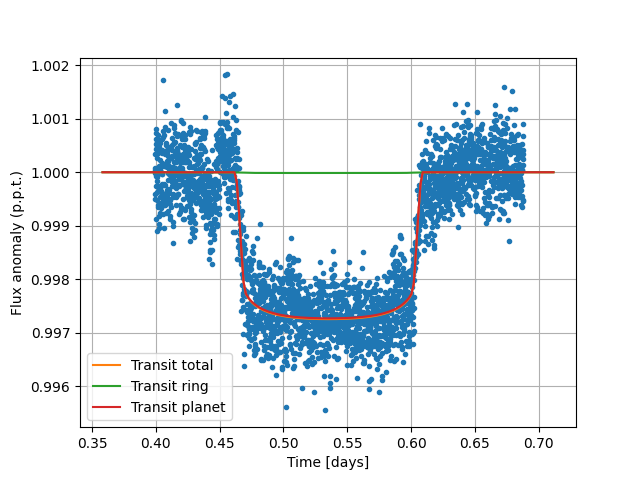

In [9]:

save_name = "/home/allard/Data/Transit_fit_checked/run_num14/rn14_fitness0.00049737_x1_14.2_.pkl"
with open(save_name,"rb") as f:
    save_file = pickle.load(f)
    
true_anomaly = np.array(save_file["lambda"])
alpha = np.array(save_file["alpha"])
Stot = np.array(save_file["Stot"])
Sp   = np.array(save_file["Sp"])
Sr   = np.array(save_file["Sr"])
Ptot = np.array(save_file["Ptot"])
Pp   = np.array(save_file["Pp"])
Pr   = np.array(save_file["Pr"])
Ttot = np.array(save_file["Ttot"])
Tp   = np.array(save_file["Tp"])
Tr   = np.array(save_file["Tr"])
tr   = np.array(save_file["tr cond"])
betas= save_file["betas"]
ts   = np.array(save_file["Time"])
fitx = save_file["Fitx"]
fity = save_file["Fity"]
x    = save_file["x"]
shift = save_file["Shift"]

betas_ls = []
for ii,ls in enumerate(betas):
    betas_ls += [np.mean(ls)]
    
betas_ls = np.array(betas_ls)

fig1=plt.figure()
ax1=fig1.gca()

ax1.plot(fitx,fity, '.')
# ax1.plot(true_anomaly,Stot[:,0]/1e6+1, label="Total")
# ax1.plot(ts+shift,Sp[:,0]/1e6+1, label="Planet")
# ax1.plot(ts+shift,Sr[:,0]/1e6+1, label="Ring")
ax1.plot(ts+shift, Ttot+1, label="Transit total")
ax1.plot(ts+shift, Tr+1, label="Transit ring")
ax1.plot(ts+shift, Tp+1, label="Transit planet")
# ax1.plot(true_anomaly, np.sum(tr,axis=1)/np.max(np.sum(tr,axis=1)), label="Transit ring")
# ax1.plot(true_anomaly, betas_ls, label="Transit ring")

ax1.legend()
ax1.set_ylabel("Flux anomaly (p.p.t.)")
ax1.set_xlabel("Time [days]")
ax1.grid()
plt.show()

In [54]:
save_location = "/home/allard/Images/Animation/Transit/"

pixx_sys = System()
fname_ring = f"./fou_files/Ring/fou_ring_0_01_0_3.dat"
aR = x[4]*(1-x[5])*pixx_sys.ul/(0.75*Consts.rsun) # In terms of stellar radius
orbit_i = np.arccos(x[0]/aR)/Consts.deg
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(orbit_i,x[1],x[2])

s=pixx_sys.add(kind="Star",physics=dict(radius=0.75*Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[x[8],x[9]]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=x[3]*Consts.rjupiter/pixx_sys.ul,
               orbit=dict(a=x[4], e=x[5]),
               physics=dict(radius=x[3]*Consts.rjupiter/pixx_sys.ul),
               optics=dict(nspangles=2000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=x[6], fe=x[7], i=gamma),
               optics=dict(nspangles=2000))

RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet="./fou_files/Planet/fou_bmsca60.0_asurf0.5.dat",
                            fname_ring=fname_ring)
RP.behavior["interp_method_ring"] = "bilinear"
thetas=RP.thetas

lamb_initial=lamb_star - thetas - 4*RP.fe*RP.thetap
lamb_final=lamb_star + thetas + 4*RP.fe*RP.thetap
lambs = np.linspace(lamb_initial,lamb_final,200)

lq = np.linspace(0,2*np.pi,200)
d_max = 0
lambq_max = 0
for ii,l in enumerate(lq):
    RP.lambq = l
    RP.changeStellarPosition(lamb_initial)
    d = RP.rstar
    if d >= d_max:
        d_max = d
        lambq_max = l

RP.lambq = lambq_max

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

for ii,lamb in enumerate(lambs):
    RP.changeStellarPosition(lamb)
    RP._updateGeometricalFactors()
    RP._updateIncomingStellarFlux()
    RP._updateObservedFacetAreas()
    junk1,fig,junk2 = RP.plotRingedPlanet(showstar=True,showfig=False)
    fig.savefig(save_location + \
                    f"fig_with_transit_{ii}_obs.png", dpi=600)


In [60]:
print(np.exp(-1/np.cos(np.pi/2+1e-9)))

inf
